In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.segmentation import quickshift
from PIL import Image
from tqdm import tnrange, tqdm_notebook

%matplotlib notebook

In [2]:
# попытка подключить osgeo через PIP или с инсталлятора
#!pip install gdal # не работает через стандартный репозиторий

# !set PATH=%PATH%;C:\OSGeo4W64\bin 
#!set path = %PYTHONPATH%;C:\OSGeo4W64\share\gdal;C:\OSGeo4W64\apps\Python37\lib\site-packages
#!set GDAL_DATA = C:\OSGeo4W64\share\gdal
#!set GDAL_LIBRARY_PATH = C:\OSGeo4W64\bin\gdal204
#!set OSGEO4W_ROOT=C:\OSGeo4W64

In [3]:
# в итоге для запуска на Win10 пришлось ставить из неофициальных бинарных сборок с
# с https://www.lfd.uci.edu/~gohlke/pythonlibs/

# !pip install GDAL-2.4.1-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install Fiona-1.8.6-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install rasterio-1.0.22-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install Cartopy-0.17.0-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз

In [4]:
import sys
# sys.path.append('C:/OSGeo4W64/apps/Python37/lib/site-packages')
# sys.path.append('C:/OSGeo4W64/bin')
# sys.path.append('C:/OSGeo4W64/share/gdal')
#import osgeo
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

# Загрузка изображения
http://geoinformaticstutorial.blogspot.com/2016/02/k-means-clustering-of-satellite-images.html

In [5]:
filename = "CIR_531.tif"
ds = gdal.Open(filename, gdalconst.GA_ReadOnly)

sarraster = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
print()

# https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
def pixel2coord(x, y):
    xoff, a, b, yoff, d, e = gt
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)

# https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
def pixel2coord(arr):
    if type(arr) is not np.ndarray:
        raise Exception('pixel2coord()', 'Argument is not numpy array')
    if arr.shape[1] != 2:
        raise Exception('pixel2coord()', 'Shape of array is not [X,2], shape=' + arr.shape)
    xoff, a, b, yoff, d, e = gt
    result = np.zeros(arr.shape)
    for i in range(0,arr.shape[0]):
        matr=np.array([[a,b],[d,e]])
        result[i,:]=matr.dot(arr[i,:].transpose())+np.array([xoff,yoff]).transpose()
    return result.transpose()

# проверка корректности загрузки, информация о файле
print("*** GetProjection() = ",proj,"\n")
print("*** gdal.Open() = ",ds,"\n")
print("*** ReadAsArray().shape = ",sarraster.shape,"\n")
print("*** GetGeoTransform() = ",gt,"\n")
ds = None # для экономии памяти

# изменение формата с [3, y, x] на [y, x, 3]
X0 = 1000
Y0 = 1000
sarraster2 = np.rollaxis(sarraster[:,X0:11000,Y0:15000],0,3)
sarraster = None # для экономии памяти


*** GetProjection() =  PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]] 

*** gdal.Open() =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001BE2CD34C00> > 

*** ReadAsArray().shape =  (3, 18211, 29327) 

*** GetGeoTransform() =  (562694.6024457472, 0.16602883283186692, 0.0, 6154009.257101998, 0.0, -0.16602883283187972) 



## Визуализация с Matplotlib

(10000, 14000, 3)


<IPython.core.display.Javascript object>


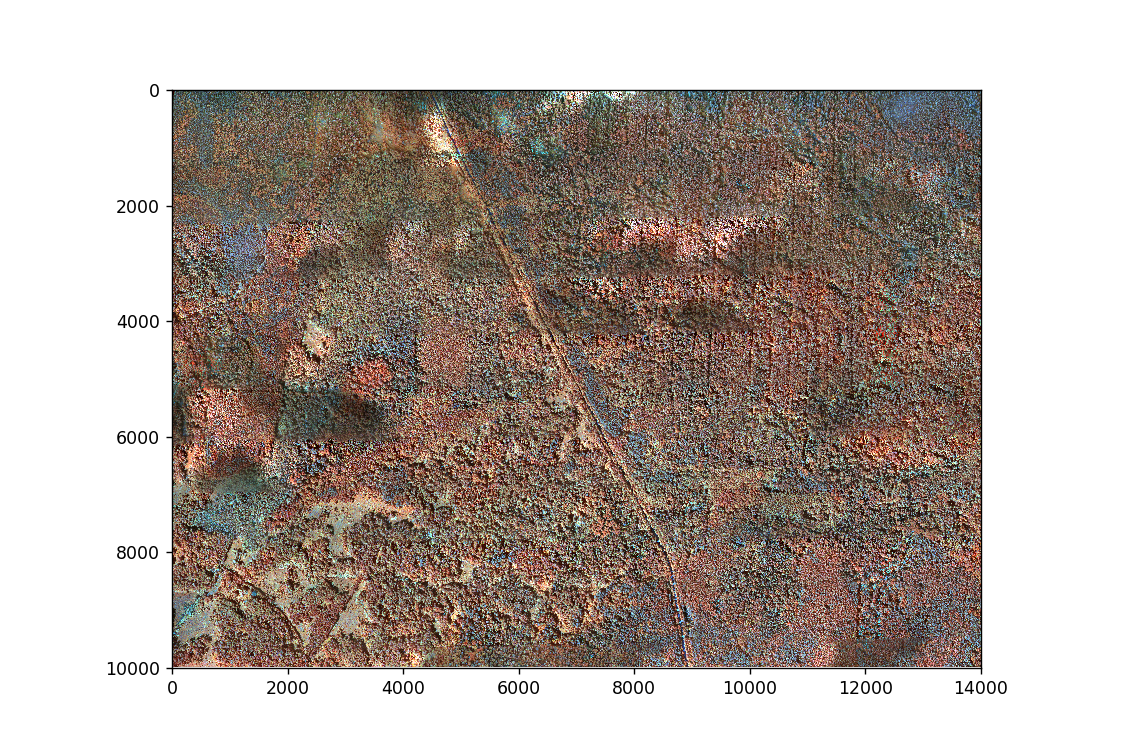

In [6]:
# иногда может потребоваться повторный запуск ячейки для переключения
# matplotlib-изображения в интерактивный режим
# (нужно для изменения увеличения при осмотре подборе параметров)
%matplotlib notebook
print(sarraster2.shape)
plt.figure(figsize=(9,6))
plt.imshow(sarraster2)    
plt.show()

## -GDAL

In [9]:
# эта визуализация не доведена

# srcband = ds.GetRasterBand(0)
# dst_layername = "POLYGONIZED_STUFF"
# drv = ogr.GetDriverByName("ESRI Shapefile")
# dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
# dst_layer = dst_ds.CreateLayer(dst_layername, srs = None )
# gdal.Polygonize( srcband, None, dst_layer, -1, [], callback=None )

## -Cartopy

In [10]:
# эта визуализация не доведена

# !pip install geos # раскомментировать при запуске в первый раз
# !pip install proj # раскомментировать при запуске в первый раз
# import cartopy.crs as ccrs

# projcs = inproj.GetAuthorityCode('PROJCS')
# projection = ccrs.epsg(projcs)
# print(projection)

## +Rasterio

<IPython.core.display.Javascript object>


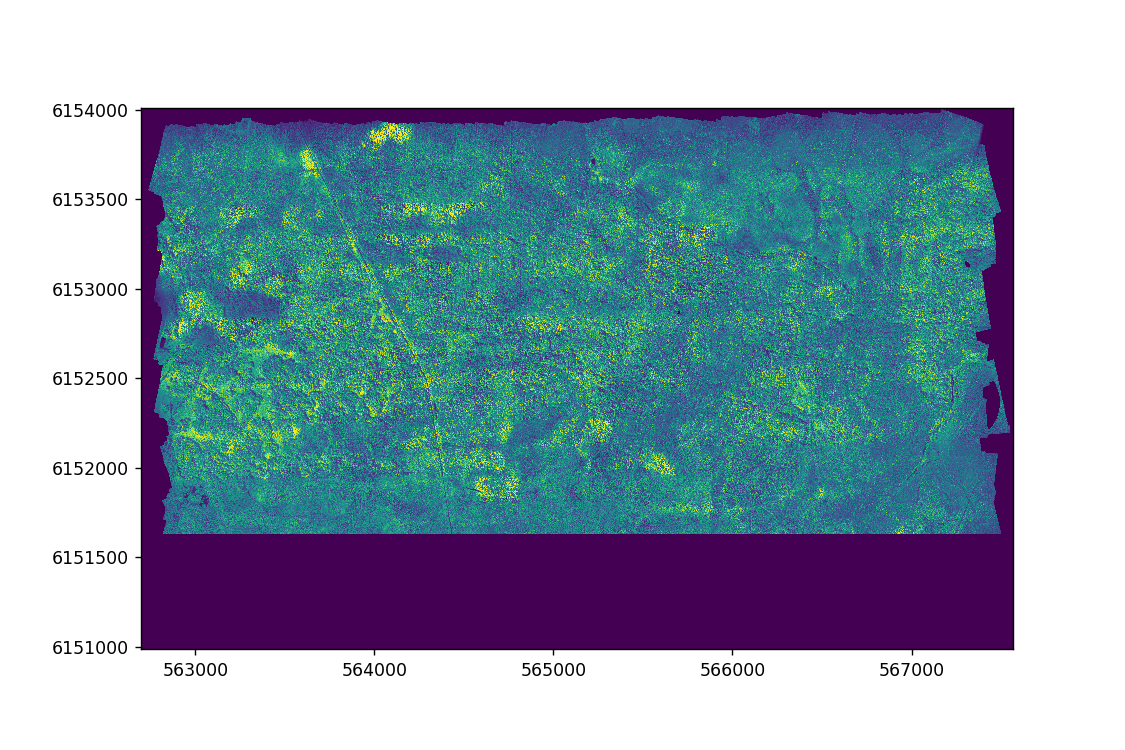

In [9]:
import rasterio
from rasterio.plot import show

ds2 = rasterio.open('CIR_531.tif')
fig2 = plt.figure(figsize=(9,6))
show(ds2)
ds2 = None

## -IPython.core.display.Image

In [11]:
# не работает, крашит весь ноутбук

# from IPython.core.display import Image, display
# import IPython.core.display as IPy
# IPython.display.display(IPy.Image(sarraster2[0:1000,0:1000,:], width=100, unconfined=True))

## -PIL

In [12]:
# не доведено
# import PIL
# import IPython

# pil_im = PIL.Image.fromarray(sarraster2) 
# IPython.display(pil_im)

# Пороговая фильтрация

<IPython.core.display.Javascript object>


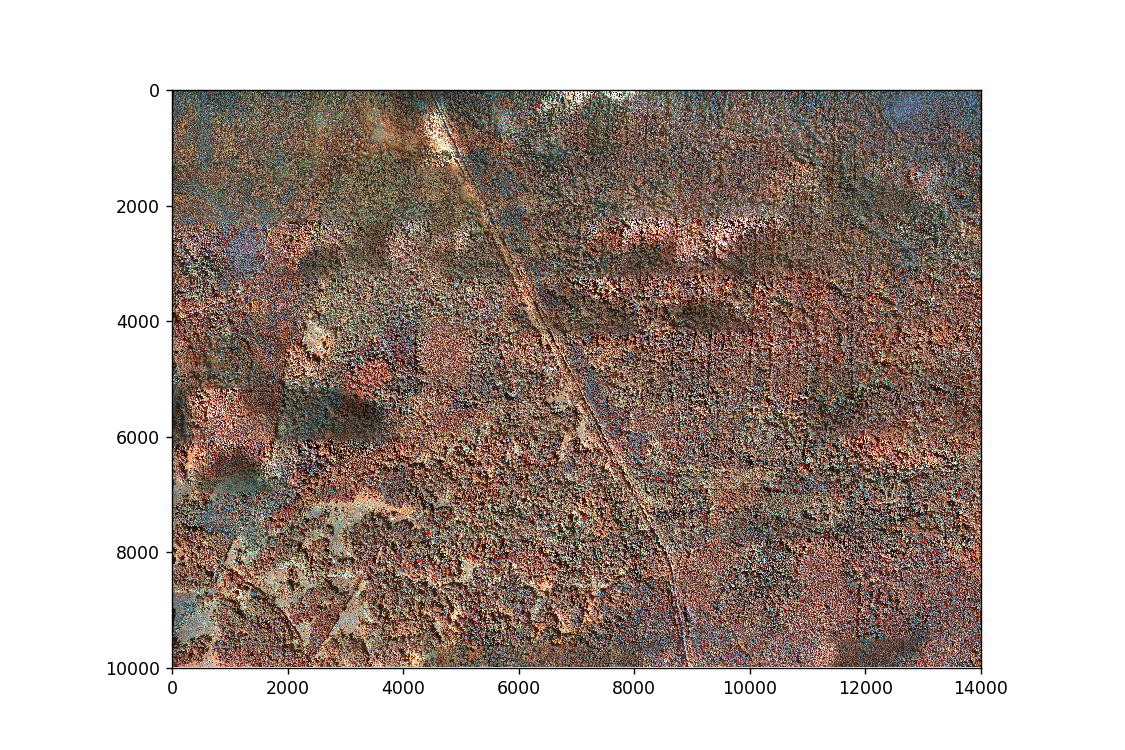

In [13]:
lower_blue = np.array([90,180,180]) # RGB
upper_blue = np.array([150,255,255]) # RGB
mask_orig = cv2.inRange(sarraster2, lower_blue, upper_blue)
mask_inv = cv2.bitwise_not(mask_orig)

redImg = np.zeros((mask_orig.shape[0], mask_orig.shape[1], 3), mask_orig.dtype)
redImg[:,:] = (255, 0, 0)
redMask = cv2.bitwise_and(redImg, redImg, mask=mask_orig)
sarraster3 = cv2.bitwise_and(sarraster2, sarraster2, mask=mask_inv)
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html
# sarraster3 = cv2.addWeighted(redMask, 1, sarraster2, 0, 0.0, sarraster2)

# sarraster3 = np.copy(sarraster2)
# sarraster3[mask_orig] = (0, 0, 255)
plt.figure(figsize=(9,6))
plt.imshow(cv2.add(sarraster3,redMask))
#plt.imshow(redMask)
plt.show()
redImg = None
redMask = None
sarraster3 = None
mask_inv = None

# Морфология

In [14]:
# mask_morph = cv2.erode(mask_orig, None, iterations=1) # убрать однопиксельные включения, число итераций подбирается
# mask_morph = cv2.dilate(mask_morph, None, iterations=3) # число итераций подбирается


## Оконтуривание (простое)

In [15]:
# mask2=np.copy(mask)
# contours, hierarchy = cv2.findContours(mask2,
#                                         cv2.RETR_TREE,#cv2.RETR_EXTERNAL,#
#                                         cv2.CHAIN_APPROX_SIMPLE)
# sarraster3=np.copy(sarraster2)

# cv2.drawContours( sarraster3, contours, -1, (0,0,255),
#                  3, cv2.LINE_AA, hierarchy, 1 )
# fig3 = plt.figure(figsize=(9,9))
# cv2.drawContours(sarraster3, contours, -1, (255,0, 0), 50)
# plt.imshow(sarraster3)  
# plt.show()
# sarraster3 = None

# Кластеризация

In [16]:
# проверки размерностей и параметров
print(mask_orig[2][2])
nonzero_points=np.nonzero(mask_orig)
print(len(nonzero_points[1])) #([i,i,i],[j,j,j],[k,k,k])
print(mask_orig.shape)
point_cloud= np.vstack((nonzero_points[1],nonzero_points[0])).transpose()
print(point_cloud.shape)

0
1130437
(10000, 14000)
(1130437, 2)


## -HDBScan
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [17]:
# кластеризация с hdbscan, не доведена до приемлемых результатов, очень медленно работает
import seaborn as sns
import sklearn.cluster as cluster
import hdbscan
import time

#!pip install seaborn # раскомментировать при запуске в первый раз
#!pip install hdbscan # раскомментировать при запуске в первый раз

# def plot_clusters(data, algorithm, args, kwds):
#     #start_time = time.time()
#     labels = algorithm(*args, **kwds).fit_predict(data)
#     print(labels)
#     #end_time = time.time()
#     palette = sns.color_palette('deep', np.unique(labels).max() + 1)
#     colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
#     plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
#     plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
# plot_clusters(point_cloud, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

## DBSCAN (sklearn.cluster)

In [18]:
# from sklearn.preprocessing import StandardScaler
# point_cloud_fit = StandardScaler().fit_transform(point_cloud)

In [19]:
from sklearn.cluster import DBSCAN
# подбор eps и min_samples
# clustering = DBSCAN(eps=50, min_samples=100).fit(point_cloud)
# labels = clustering.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)
# print(n_clusters_)
# print(n_noise_)

In [20]:
# !!! выполнение занимает около 1 минуты

from sklearn.cluster import DBSCAN
# подбор eps и min_samples
clustering = DBSCAN(eps=100, min_samples=500, metric='euclidean').fit(point_cloud)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)

167
265365


In [26]:
# диагностическая печать

labels = clustering.labels_
print(len(set(labels))-(1 if -1 in labels else 0))
#points_filtered = point_cloud[df.tweet_cluster_labels>-1]
print(point_cloud.shape)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)

167
(1130437, 2)
167
265365


In [27]:
# черновик

# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = point_cloud[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = point_cloud[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

<IPython.core.display.Javascript object>


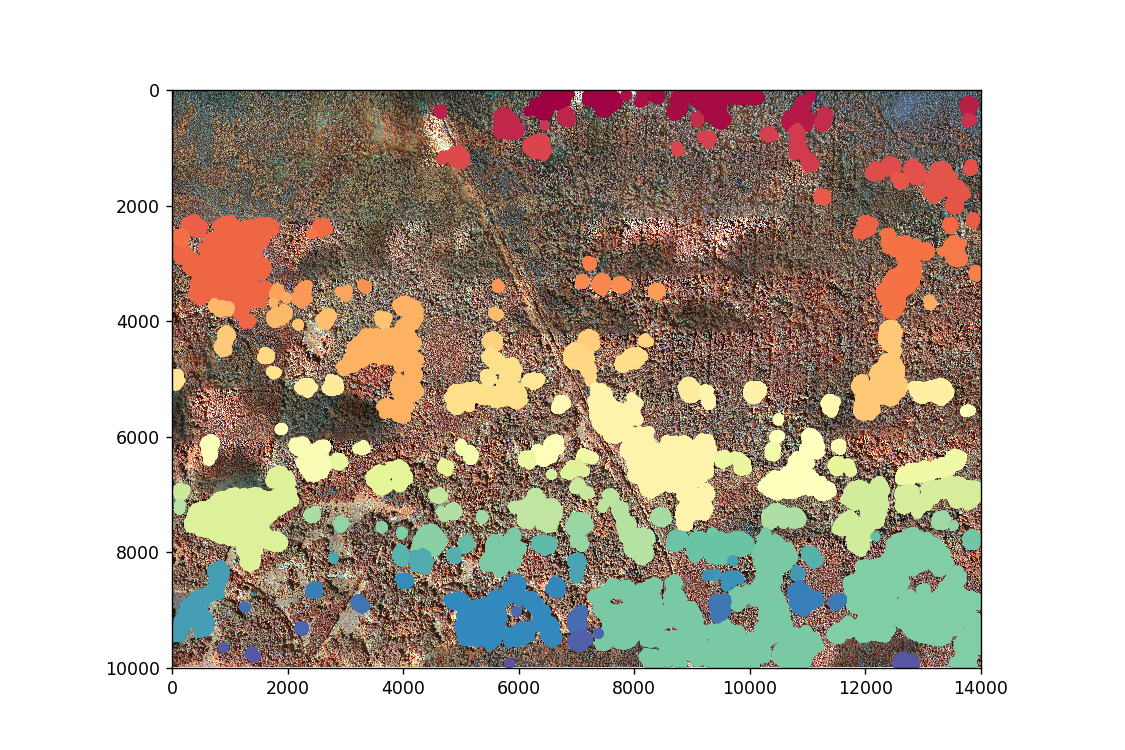

In [28]:
# вспомогательная визуализация

fig = plt.figure(figsize=(9,6))
plt.imshow(sarraster2)

unique_labels = set(labels) # отсев повторяющихся 
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in tqdm_notebook(zip(unique_labels, colors), total=len(unique_labels)):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)  
    # точки, входящие в выделенные кластеры
    xy = point_cloud[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor=col, markersize=5)
    # шум
    # xy = point_cloud[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
    #              markeredgecolor='cyan', markersize=1)

plt.show()

# Оконтуривание кластеров
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.spatial.ConvexHull.html

## 1. -ConvexHull

In [29]:
from scipy.spatial import ConvexHull
# разбить по label-ам
#allPoints=np.column_stack((LATS,LONGS))
# оконтурить
#hullPoints = ConvexHull(allPoints)

## 2
http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

https://gist.github.com/dwyerk/10561690

In [30]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import shapely.geometry as geometry
import math
#!pip install descartes # раскомментировать при первом запуске
from descartes import PolygonPatch

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    tri = Delaunay(points)
    edges = set()
    edge_points = []
    for ia, ib, ic in tri.vertices:# цикл по выделенным по Делоне треугольникам
        # ia, ib, ic = вершины треугольников
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area) # диаметр описанной окружности
        if circum_r < 1.0/alpha: # добавлять только достаточно небольшие треугольники
            add_edge(edges, edge_points, points, ia, ib)
            add_edge(edges, edge_points, points, ib, ic)
            add_edge(edges, edge_points, points, ic, ia)
    m = geometry.MultiLineString(edge_points) # https://shapely.readthedocs.io/en/stable/manual.html
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [31]:
coords = np.array([point_cloud[0] for point in point_cloud])
print(coords.shape)

(1130437, 2)


<IPython.core.display.Javascript object>


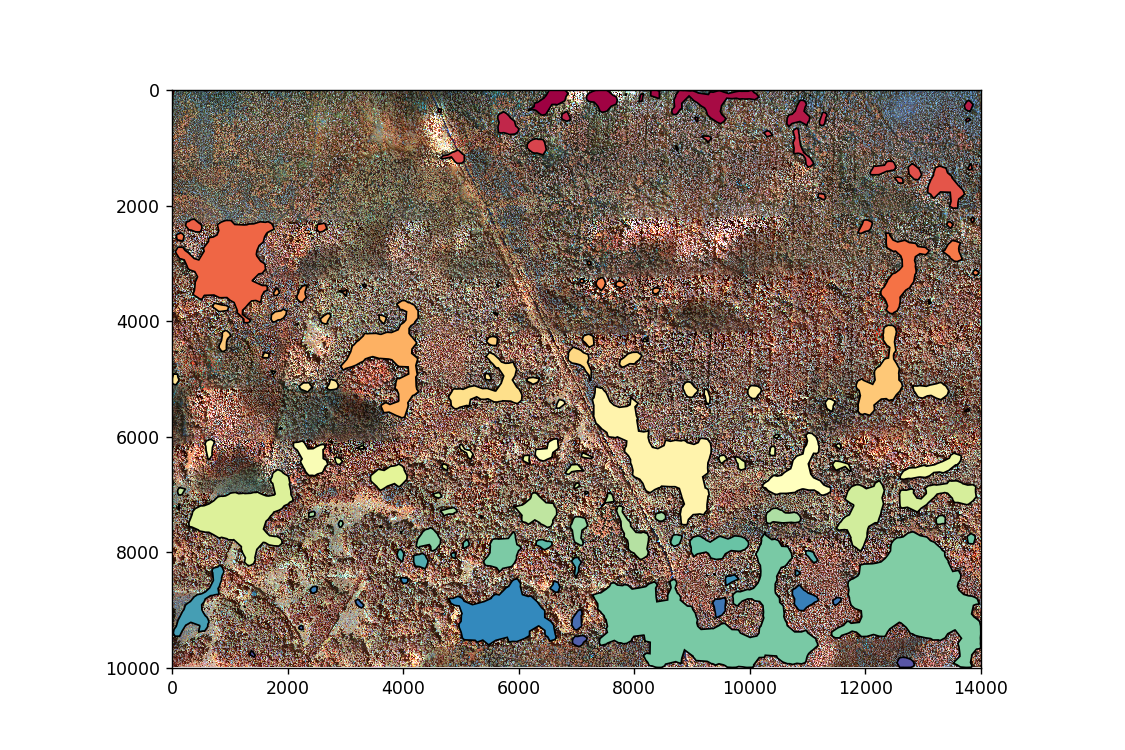

In [32]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.imshow(sarraster2)
polygons = []
for k, col in tqdm_notebook( zip(list(unique_labels), colors), total=len(unique_labels)):
    class_member_mask = (labels == k)
    xy = point_cloud[class_member_mask & core_samples_mask]
    #print("\t*** xy.shape = ", xy.shape) # TODO как под 15-м номером оказалась одна вершина???
    if xy.shape[0] < 4:
        continue
    concave_hull, edge_points = alpha_shape(xy, alpha=0.01)
    polygons.append(concave_hull)
    patch = PolygonPatch(concave_hull,
                         fc=col,
                         ec='#000000',
                         fill=True,
                         zorder=1)
    ax.add_patch(patch)

## 3
https://towardsdatascience.com/the-concave-hull-c649795c0f0f

In [31]:
#TODO

## 4

https://pdfs.semanticscholar.org/2397/17005c3ebd5d6a42fc833daf97a0edee1ce4.pdf

In [32]:
#TODO

## 5
https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points/50714300#50714300

In [33]:
from scipy.spatial import Delaunay

# TODO

# Преобразование контуров из растровых координат в географические

In [34]:
# np_arr=np.asarray(polygons[3].exterior.coords)
# print(np_arr)
# print(pixel2coord(np_arr))
coords = []
for i in range(0,len(polygons)):
    np_arr=np.asarray(polygons[i].exterior.coords)
    coords.append(pixel2coord(np_arr))

In [35]:
#!pip install sentinelhub
from sentinelhub import pixel_to_utm
coords = []

# https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
# !!!https://gis.stackexchange.com/questions/78838/converting-projected-coordinates-to-lat-lon-using-python
def pixel2coord2(arr):
    if (type(arr) is not np.ndarray):
        raise Exception('pixel2coord()', 'Argument is not numpy array of list')
    if arr.shape[1] != 2:
        raise Exception('pixel2coord()', 'Shape of array is not [X,2], shape=' + arr.shape)
    result = np.zeros(arr.shape)
    for i in range(0,arr.shape[0]):
        result[i,:]=np.array( pixel_to_utm(arr[i,0], arr[i,1], gt))
    return result

for i in range(0,len(polygons)):
    np_arr=np.asarray(polygons[i].exterior.coords)
    #print(np_arr)
    np_arr = np_arr + [X0, Y0]
    #print(np_arr)
    coords.append(pixel2coord(np_arr))

In [49]:
coords[1]

array([[ 562722.163232  ,  562720.83500133,  562717.68045351,
         562712.20150203,  562712.03547319,  562705.89240638,
         562703.40197389,  562698.08905124,  562697.9230224 ,
         562695.10053225,  562695.10053225,  562695.26656108,
         562695.10053225,  562694.60244575,  562694.60244575,
         562694.93450341,  562694.60244575,  562694.60244575,
         562694.93450341,  562695.76464758,  562700.08139723,
         562701.74168556,  562706.22446405,  562708.88092537,
         562714.35987685,  562722.49528966,  562723.65749149,
         562725.64983749,  562735.27950979,  562740.42640361,
         562740.59243244,  562741.25654777,  562755.20296973,
         562755.36899856,  562758.68957522,  562755.70105623,
         562741.42257661,  562734.11730796,  562729.46850064,
         562727.47615465,  562722.163232  ],
       [6152818.00022643, 6152818.49831293, 6152818.33228409,
        6152818.16625526, 6152818.16625526, 6152813.68347677,
        6152811.35907312,

In [50]:
coords[3].transpose().tolist()

[[562765.8288150321, 6152567.794775351],
 [562765.6627861992, 6152567.960804184],
 [562762.010151877, 6152572.277553838],
 [562761.5120653785, 6152572.443582671],
 [562761.01397888, 6152572.609611504],
 [562756.6972292264, 6152573.273726835],
 [562755.7010562294, 6152573.273726835],
 [562750.7201912444, 6152572.609611504],
 [562749.5579894145, 6152571.77946734],
 [562746.5694704236, 6152568.29286185],
 [562742.25272077, 6152565.4703716915],
 [562722.6613184959, 6152567.13066002],
 [562722.495289663, 6152567.13066002],
 [562712.8656173587, 6152562.315823868],
 [562708.8809253707, 6152561.983766202],
 [562707.718723541, 6152561.81773737],
 [562707.5526947081, 6152561.651708537],
 [562705.5603487141, 6152559.327304877],
 [562696.0967052428, 6152553.018209229],
 [562695.4325899114, 6152552.686151563],
 [562694.9345034129, 6152551.689978567],
 [562694.9345034129, 6152551.357920901],
 [562695.7646475771, 6152539.237816105],
 [562695.4325899114, 6152537.24547011],
 [562696.9268494069, 6152520

# Запись GeoJSON

In [37]:
#!pip3 install geojson # раскомментировать при запуске в первый раз
import geojson
#from geojson import Point, Polygon, Feature, FeatureCollection, dump

features = []
f =  open('windfall.geojson', 'w')

crs = {
    "type": "name",
    "properties": {
        "name": "urn:ogc:def:crs:EPSG::32637"
    }
}

for i in range(0,len(coords)):
    ft = geojson.Feature(geometry=geojson.Polygon([coords[i].transpose().tolist()]))
    features.append(ft)

feature_collection = geojson.FeatureCollection(features, crs = crs, name = "windfall")

geojson.dump(feature_collection, f, indent=2)
f.close()

# Визуализация с  GeoJSON

In [ ]:
#TODO